In [14]:
import pandas as pd 
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))
#from src.helpers.normalizers import DESeqNormalizer, RankNormalizer

import numpy as np

print('Correct script running...')
print(f'Numpy version: {np.__version__}')



##########################################################################################


data_layers = ['gene_id', 'ip_vars', 'etp_vars', 'pathways', 'clinical_vars',
       'variants', 'per_gene_alterations', 'subtype']

# %%
stc=['ETP-like', 'TAL1 αβ-like', 'TAL1 DP-like', 'NUP98', 'NUP214', 'MLLT10',
       'KMT2A', 'HOXA9 TCR', 'TLX3', 'NKX2-1', 'TLX1', 'TME-enriched', 'SPI1',
       'NKX2-5', 'BCL11B', 'LMO2 γδ-like', 'STAG2&LMO2','STAG2/LMO2']

def _align_xy(dfs, labels):
	"""Intersect by sample ID index across all dfs and labels; align and concatenate features horizontally."""
	common_idx = labels.index.astype(str)
	for df in dfs:
		common_idx = common_idx.intersection(df.index.astype(str))
	if len(common_idx) == 0:
		raise ValueError("No common samples between selected datasets and labels after alignment.")

	# Align and concat features
	aligned_dfs = [df.loc[common_idx].sort_index() for df in dfs]
	X = pd.concat(aligned_dfs, axis=1)
	y = labels.loc[common_idx].sort_index()

	# Basic cleaning: drop all-NaN columns, fill remaining NaNs with 0
	X = X.dropna(axis=1, how="all").fillna(0)
	# Ensure numeric dtype (convert booleans to ints)
	for col in X.columns:
		if pd.api.types.is_bool_dtype(X[col]):
			X[col] = X[col].astype(np.int8)
		elif not pd.api.types.is_numeric_dtype(X[col]):
			# Attempt coercion; non-convertible become NaN then fill with 0
			X[col] = pd.to_numeric(X[col], errors="coerce").fillna(0)
	return X, y

def _read_labels(labels_path: Path, label_column: str = "Reviewed.subtype") -> pd.Series:
	df = pd.read_pickle(labels_path)
	if label_column not in df.columns:
		raise KeyError(f"Label column '{label_column}' not found in {labels_path}. Available: {list(df.columns)}")
	# Preserve original index (sample IDs)
	ser = df[label_column]
	ser = ser.astype(str)
	return ser


def _filter_labels(labels: pd.Series, exclude_terms:  None , include_terms: None) -> pd.Series:
	if not exclude_terms and not include_terms:
		return labels
	if include_terms:
		mask = pd.Series(False, index=labels.index)
		for term in include_terms:
			mask |= labels.str.contains(str(term), na=False)
		return labels[mask]
	mask = pd.Series(True, index=labels.index)
	for term in exclude_terms:
		mask &= ~labels.str.contains(str(term), na=False)
	return labels[mask]



files = {
		"Copy Number Variation": "cnvlr_final.csv",
		"DNA Variants": "DNA_variants_binary_final.csv",
		"Clinical Data": "processed_clinical_data_final_with_cns.csv",
		"Gene Expression": "Tall_gexp_cleaned.csv",}
	
datasets= {}
data_dir = Path('.')
labels = _read_labels(data_dir / "labels_final.pkl", label_column="Reviewed.subtype")
labels.index = labels.index.astype(str)
labels = _filter_labels(labels, exclude_terms=None, include_terms=stc)


Correct script running...
Numpy version: 2.2.6


In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.rcParams.update({
        "text.usetex": True,             # Use LaTeX to render text
        "font.family": "serif",          # Use serif font (matches LaTeX default)
        "font.serif": ["Computer Modern"], # Specify the font
        "font.size": 12,                 # Set this to match your document's font size (e.g., 10, 11, or 12)
        "axes.labelsize": 12,
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12
    })
# 1. Prepare Data and Metrics


gex_pred_labels = pd.read_csv('res/all_pred_labels_EFS_tuned_Combined.csv', index_col=0).idxmax(axis=1)
gex_pred_labels = pd.DataFrame([i.split('_')[1] for i in gex_pred_labels], index=gex_pred_labels.index, columns=['Predicted'])
common_samples = labels.index.intersection(gex_pred_labels.index).to_list()
gex_pred_labels = gex_pred_labels.loc[common_samples]
labels = labels.loc[common_samples]

variants_pred_labels = pd.read_csv('res/all_pred_labels_EFS_tuned_Variants.csv', index_col=0).idxmax(axis=1)
variants_pred_labels = pd.DataFrame([i.split('_')[1] for i in variants_pred_labels], index=variants_pred_labels.index, columns=['Predicted'])
common_samples = labels.index.intersection(variants_pred_labels.index).to_list()
variants_pred_labels = variants_pred_labels.loc[common_samples]
labels_var = labels.loc[common_samples]

gex_only_pred_labels = pd.read_csv('res/all_pred_labels_EFS_tuned_Gene_id.csv', index_col=0).idxmax(axis=1)
gex_only_pred_labels = pd.DataFrame([i.split('_')[1] for i in gex_only_pred_labels], index=gex_only_pred_labels.index, columns=['Predicted'])
common_samples = labels.index.intersection(gex_only_pred_labels.index)
gex_only_pred_labels = gex_only_pred_labels.loc[common_samples]
labels_gex_only = labels.loc[common_samples]

clinical_labels = pd.read_csv('res/all_pred_labels_EFS_tuned_Clinical_vars.csv', index_col=0).idxmax(axis=1)
clinical_labels = pd.DataFrame([i.split('_')[1] for i in clinical_labels], index=clinical_labels.index, columns=['Predicted'])
common_samples = labels.index.intersection(clinical_labels.index)
clinical_labels = clinical_labels.loc[common_samples]
labels_clinical = labels.loc[common_samples]

CNV_labels = pd.read_csv('res/all_pred_labels_EFS_tuned_CNV.csv', index_col=0).idxmax(axis=1)
CNV_labels = pd.DataFrame([i.split('_')[1] for i in CNV_labels], index=CNV_labels.index, columns=['Predicted'])
common_samples = labels.index.intersection(CNV_labels.index)
CNV_labels = CNV_labels.loc[common_samples]
labels_CNV = labels.loc[common_samples]

In [16]:
from sklearn.metrics import classification_report
labels_clinical = labels_clinical.replace({'LMO2 γδ-like': r'LMO2 $\gamma\delta$-like',
                         'TAL1 αβ-like': r'TAL1 $\alpha\beta$-like'})
clinical_labels = clinical_labels.replace({'LMO2 γδ-like': r'LMO2 $\gamma\delta$-like',
                         'TAL1 αβ-like': r'TAL1 $\alpha\beta$-like'})
report = classification_report(labels_clinical, clinical_labels,   output_dict=True)
pd.DataFrame(report).T

,precision,recall,f1-score,support
BCL11B,0.083333,0.055556,0.066667,18.000000
ETP-like,0.640000,0.817021,0.717757,235.000000
HOXA9 TCR,0.000000,0.000000,0.000000,21.000000
KMT2A,0.200000,0.076923,0.111111,39.000000
LMO2 $\gamma\delta$-like,0.125000,0.100000,0.111111,10.000000
MLLT10,0.333333,0.129032,0.186047,31.000000
NKX2-1,0.333333,0.116883,0.173077,77.000000
NKX2-5,0.000000,0.000000,0.000000,8.000000
NUP214,0.333333,0.200000,0.250000,5.000000
NUP98,0.000000,0.000000,0.000000,6.000000


In [17]:
from sklearn.metrics import classification_report
labels_CNV = labels_CNV.replace({'LMO2 γδ-like': r'LMO2 $\gamma\delta$-like',
                         'TAL1 αβ-like': r'TAL1 $\alpha\beta$-like'})
CNV_labels = CNV_labels.replace({'LMO2 γδ-like': r'LMO2 $\gamma\delta$-like',
                         'TAL1 αβ-like': r'TAL1 $\alpha\beta$-like'})
report = classification_report(labels_CNV, CNV_labels,   output_dict=True)
pd.DataFrame(report).T

c:\Users\stoib\miniconda3\envs\tall-analysis\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\stoib\miniconda3\envs\tall-analysis\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\stoib\miniconda3\envs\tall-analysis\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

,precision,recall,f1-score,support
BCL11B,0.000000,0.000000,0.000000,18.00000
ETP-like,0.506460,0.834043,0.630225,235.00000
HOXA9 TCR,0.000000,0.000000,0.000000,21.00000
KMT2A,0.000000,0.000000,0.000000,39.00000
LMO2 $\gamma\delta$-like,0.000000,0.000000,0.000000,10.00000
MLLT10,0.083333,0.032258,0.046512,31.00000
NKX2-1,0.346939,0.220779,0.269841,77.00000
NKX2-5,0.000000,0.000000,0.000000,8.00000
NUP214,0.000000,0.000000,0.000000,5.00000
NUP98,0.000000,0.000000,0.000000,6.00000


In [18]:
from sklearn.metrics import classification_report
labels = labels.replace({'LMO2 γδ-like': r'LMO2 $\gamma\delta$-like',
                         'TAL1 αβ-like': r'TAL1 $\alpha\beta$-like'})
gex_pred_labels = gex_pred_labels.replace({'LMO2 γδ-like': r'LMO2 $\gamma\delta$-like',
                         'TAL1 αβ-like': r'TAL1 $\alpha\beta$-like'})
report = classification_report(labels, gex_pred_labels, output_dict=True)
pd.DataFrame(report).T

c:\Users\stoib\miniconda3\envs\tall-analysis\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\stoib\miniconda3\envs\tall-analysis\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\stoib\miniconda3\envs\tall-analysis\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

,precision,recall,f1-score,support
BCL11B,1.000000,1.000000,1.000000,18.000000
ETP-like,0.932773,0.944681,0.938689,235.000000
HOXA9 TCR,0.833333,0.714286,0.769231,21.000000
KMT2A,0.833333,0.769231,0.800000,39.000000
LMO2 $\gamma\delta$-like,0.833333,1.000000,0.909091,10.000000
MLLT10,0.750000,0.774194,0.761905,31.000000
NKX2-1,0.925000,0.961039,0.942675,77.000000
NKX2-5,0.500000,0.375000,0.428571,8.000000
NUP214,0.200000,0.200000,0.200000,5.000000
NUP98,0.000000,0.000000,0.000000,6.000000


In [19]:
labels_var = labels_var.replace({'LMO2 γδ-like': r'LMO2 $\gamma\delta$-like',
                         'TAL1 αβ-like': r'TAL1 $\alpha\beta$-like'})
variants_pred_labels = variants_pred_labels.replace({'LMO2 γδ-like': r'LMO2 $\gamma\delta$-like',
                         'TAL1 αβ-like': r'TAL1 $\alpha\beta$-like'})
report2 = classification_report(labels_var, variants_pred_labels, output_dict=True)
pd.DataFrame(report2).T

c:\Users\stoib\miniconda3\envs\tall-analysis\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\stoib\miniconda3\envs\tall-analysis\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\stoib\miniconda3\envs\tall-analysis\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

,precision,recall,f1-score,support
BCL11B,0.937500,0.833333,0.882353,18.000000
ETP-like,0.796154,0.880851,0.836364,235.000000
HOXA9 TCR,0.869565,0.952381,0.909091,21.000000
KMT2A,0.853659,0.897436,0.875000,39.000000
LMO2 $\gamma\delta$-like,0.000000,0.000000,0.000000,10.000000
MLLT10,0.846154,0.709677,0.771930,31.000000
NKX2-1,0.890411,0.844156,0.866667,77.000000
NKX2-5,1.000000,0.375000,0.545455,8.000000
NUP214,0.000000,0.000000,0.000000,5.000000
NUP98,0.500000,0.166667,0.250000,6.000000


In [20]:

labels_gex_only = labels_gex_only.replace({'LMO2 γδ-like': r'LMO2 $\gamma\delta$-like',
                         'TAL1 αβ-like': r'TAL1 $\alpha\beta$-like'})
gex_only_pred_labels = gex_only_pred_labels.replace({'LMO2 γδ-like': r'LMO2 $\gamma\delta$-like',
                         'TAL1 αβ-like': r'TAL1 $\alpha\beta$-like'})
report3 = classification_report(labels_gex_only, gex_only_pred_labels, output_dict=True)
pd.DataFrame(report3).T

c:\Users\stoib\miniconda3\envs\tall-analysis\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\stoib\miniconda3\envs\tall-analysis\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\stoib\miniconda3\envs\tall-analysis\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

,precision,recall,f1-score,support
BCL11B,0.941176,0.888889,0.914286,18.000000
ETP-like,0.940678,0.944681,0.942675,235.000000
HOXA9 TCR,0.800000,0.761905,0.780488,21.000000
KMT2A,0.871795,0.871795,0.871795,39.000000
LMO2 $\gamma\delta$-like,0.875000,0.700000,0.777778,10.000000
MLLT10,0.650000,0.838710,0.732394,31.000000
NKX2-1,0.902439,0.961039,0.930818,77.000000
NKX2-5,0.333333,0.125000,0.181818,8.000000
NUP214,0.000000,0.000000,0.000000,5.000000
NUP98,0.000000,0.000000,0.000000,6.000000


In [21]:
comb = pd.DataFrame(report2).T.join(pd.DataFrame(report3).T, lsuffix='_variants', rsuffix='_gex_only').join(pd.DataFrame(report).T, lsuffix='', rsuffix='_all',)   
comb[[i for i in comb.columns if 'recall' in i]]

,recall_variants,recall_gex_only,recall
BCL11B,0.833333,0.888889,1.000000
ETP-like,0.880851,0.944681,0.944681
HOXA9 TCR,0.952381,0.761905,0.714286
KMT2A,0.897436,0.871795,0.769231
LMO2 $\gamma\delta$-like,0.000000,0.700000,1.000000
MLLT10,0.709677,0.838710,0.774194
NKX2-1,0.844156,0.961039,0.961039
NKX2-5,0.375000,0.125000,0.375000
NUP214,0.000000,0.000000,0.200000
NUP98,0.166667,0.000000,0.000000


In [22]:
# get labels consistent between gex and labels and unique_labels
# they must get formatted for latex, alpha, beta delta and gamma 
labels = labels.replace({'LMO2 γδ-like': r'LMO2 $\gamma\delta$-like',
                         'TAL1 αβ-like': r'TAL1 $\alpha\beta$-like'})   
unique_labels = sorted(labels.unique())
gex_pred_labels = gex_pred_labels.replace({'LMO2 γδ-like': r'LMO2 $\gamma\delta$-like',
                         'TAL1 αβ-like': r'TAL1 $\alpha\beta$-like'})

In [23]:
from sksurv.metrics import cumulative_dynamic_auc, integrated_brier_score, concordance_index_censored
from sksurv.util import Surv
# 1. Load your data
df_clin = pd.read_csv('clinical.csv', index_col=0) 
eta_preds = pd.read_csv('res/eta_per_cause_EFS_tuned_Combined.csv', index_col=0) # Your precomputed risk scores (N, K)
annotations = pd.read_csv('annotations.csv', index_col=0)
annotations['Event.Type'].replace({'Induction death': 'Death NOS'}, inplace=True)
annotations.fillna({'Event.Type': 'Censored'}, inplace=True)
annotations['Event.Type'].value_counts()
et_to_idx = {"Censored":0, "Relapse":1, "Toxic Death":2, "Induction failure":3, "Second Malignant Neoplasm":4, "Death NOS":5}
event_types = annotations['Event.Type'].map(et_to_idx)
event_types.value_counts()
# align index of event_types with df_clin
common_idx = df_clin.index.intersection(event_types.index).intersection(eta_preds.index)
common_idx = list(common_idx)
eta_preds = eta_preds.loc[common_idx]
df_clin = df_clin.loc[common_idx]
event_types = event_types.loc[common_idx]

C:\Users\stoib\AppData\Local\Temp\ipykernel_36452\3906235518.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  annotations['Event.Type'].replace({'Induction death': 'Death NOS'}, inplace=True)


In [24]:
import numpy as np
import pandas as pd
from sksurv.util import Surv
from sksurv.metrics import (
    concordance_index_censored,
    cumulative_dynamic_auc,
    brier_score,
    integrated_brier_score
)

# =============================================================================
# 1. Prepare Data
# =============================================================================
# Assume df_clin and event_types are already defined
# event_type: 0=Censored, 1=Relapse, 2=TRM, etc.
durations = df_clin['EFS_days'].values
event_type = event_types.values
K = int(event_type.max())  # Number of causes

# Create structured array for the whole dataset
y_full = Surv.from_arrays(event=(event_type > 0), time=durations)

# =============================================================================
# 2. Define Evaluation Time Points
# =============================================================================
# Time points in days (e.g., 180d, 1yr, 3yr)
times = [180, 365, 1095]
times = [t for t in times if durations.min() < t < durations.max()]
print(f"Evaluating at horizons: {times} days")

# =============================================================================
# 3. Helper Function: Breslow Estimator for Survival Probabilities
# =============================================================================
def get_survival_probs_breslow(eta, durations, events, eval_times):
    """
    Reconstructs Survival Probabilities S(t) = exp(-H0(t)*exp(eta))
    using the Breslow estimator.
    
    Parameters
    ----------
    eta : array-like
        Log-hazard ratios (linear predictor from Cox model)
    durations : array-like
        Observed survival times
    events : array-like
        Event indicators (1=event, 0=censored)
    eval_times : array-like
        Time points at which to evaluate survival probabilities
        
    Returns
    -------
    ndarray
        Survival probabilities, shape (n_samples, n_times)
    """
    # Sort data by time
    idx = np.argsort(durations)
    sorted_times = durations[idx]
    sorted_events = events[idx]
    sorted_exps = np.exp(eta[idx])
    
    # Calculate risk set sums (denominator of Breslow)
    risk_sums = np.cumsum(sorted_exps[::-1])[::-1]
    
    # Calculate cumulative baseline hazard at event times
    event_mask = sorted_events == 1
    uniq_event_times = np.unique(sorted_times[event_mask])
    
    dH = []
    for t in uniq_event_times:
        deaths = ((sorted_times == t) & (sorted_events == 1)).sum()
        first_idx = np.searchsorted(sorted_times, t, side='left')
        denom = risk_sums[first_idx]
        dH.append(deaths / denom)
    
    H0 = np.cumsum(dH)  # Cumulative baseline hazard
    
    # Interpolate H0 to requested evaluation times
    idx_eval = np.searchsorted(uniq_event_times, eval_times, side='right') - 1
    H0_eval = np.zeros_like(eval_times, dtype=float)
    valid_mask = idx_eval >= 0
    H0_eval[valid_mask] = H0[idx_eval[valid_mask]]
    
    # Compute S(t|x) for all samples
    cumulative_hazard = np.outer(np.exp(eta), H0_eval)
    surv_probs = np.exp(-cumulative_hazard)
    
    return surv_probs

# =============================================================================
# 4. Calculate Metrics
# =============================================================================
results = {}

# --- A. Overall Risk (Any Event) ---
print("\nCalculating Overall metrics...")
risk_overall = np.sum(np.exp(eta_preds.values), axis=1)
log_risk_overall = np.log(risk_overall)

# C-Index
try:
    c_index_overall = concordance_index_censored(
        y_full['event'], y_full['time'], risk_overall
    )[0]
    results['Overall_C_Index'] = c_index_overall
except ValueError as e:
    print(f"Error calculating Overall C-index: {e}")

# Time-dependent AUC
try:
    auc_any, mean_auc_any = cumulative_dynamic_auc(
        y_full, y_full, risk_overall, times
    )
    results['Overall_AUC_Mean'] = mean_auc_any
    for t, auc in zip(times, auc_any):
        results[f'Overall_AUC_{t}d'] = auc
except ValueError as e:
    print(f"Error calculating Overall AUC: {e}")

# Brier Score
try:
    surv_probs_overall = get_survival_probs_breslow(
        log_risk_overall, durations, (event_type > 0).astype(int), times
    )
    
    ibs_overall = integrated_brier_score(y_full, y_full, surv_probs_overall, times)
    results['Overall_IBS'] = ibs_overall
    
    _, bs_scores = brier_score(y_full, y_full, surv_probs_overall, times)
    for t, bs in zip(times, bs_scores):
        results[f'Overall_Brier_{t}d'] = bs
except Exception as e:
    print(f"Error calculating Overall Brier: {e}")

# --- B. Cause-Specific Risks ---
print("\nCalculating Cause-Specific metrics...")
for k in range(1, K + 1):
    cause_name = f"Cause_{k}"
    print(f"  Processing {cause_name}...")
    
    # Create cause-specific target (event k vs. censored/competing)
    y_cs = Surv.from_arrays(event=(event_type == k), time=durations)
    eta_k = eta_preds.values[:, k-1]
    
    # C-Index
    try:
        c_index_cs = concordance_index_censored(
            y_cs['event'], y_cs['time'], eta_k
        )[0]
        results[f'{cause_name}_C_Index'] = c_index_cs
    except ValueError as e:
        print(f"    Error calculating C-index: {e}")
    
    # Time-dependent AUC
    try:
        auc_cs, mean_auc_cs = cumulative_dynamic_auc(y_cs, y_cs, eta_k, times)
        results[f'{cause_name}_AUC_Mean'] = mean_auc_cs
        for t, auc in zip(times, auc_cs):
            results[f'{cause_name}_AUC_{t}d'] = auc
    except ValueError as e:
        print(f"    Error calculating AUC: {e}")
    
    # Brier Score
    try:
        surv_probs_cs = get_survival_probs_breslow(
            eta_k, durations, (event_type == k).astype(int), times
        )
        
        ibs_cs = integrated_brier_score(y_cs, y_cs, surv_probs_cs, times)
        results[f'{cause_name}_IBS'] = ibs_cs
        
        _, bs_scores = brier_score(y_cs, y_cs, surv_probs_cs, times)
        for t, bs in zip(times, bs_scores):
            results[f'{cause_name}_Brier_{t}d'] = bs
    except Exception as e:
        print(f"    Error calculating Brier: {e}")

# =============================================================================
# 5. Format and Display Results
# =============================================================================
# Reshape results into a clean DataFrame
reshaped_data = {}

for key, value in results.items():
    if key.startswith("Overall_"):
        group = "Overall"
        metric = key.replace("Overall_", "")
    elif key.startswith("Cause_"):
        parts = key.split('_')
        group = f"{parts[0]}_{parts[1]}"
        metric = "_".join(parts[2:])
    else:
        continue
    
    if metric not in reshaped_data:
        reshaped_data[metric] = {}
    reshaped_data[metric][group] = value

# Create DataFrame with metrics as rows, event types as columns
df_results = pd.DataFrame(reshaped_data).T

# Sort columns: Overall first, then Causes by number
def sort_cols(col_name):
    if col_name == 'Overall':
        return (0, 0)
    return (1, int(col_name.split('_')[1]))

sorted_cols = sorted(df_results.columns, key=sort_cols)
df_results = df_results[sorted_cols]

# Rename columns with meaningful names
event_type_names = {
    'Overall': 'Overall',
    'Cause_1': 'Relapse',
    'Cause_2': 'Toxic Death',
    'Cause_3': 'Induction Failure',
    'Cause_4': 'Second Malignant Neoplasm',
    'Cause_5': 'Death NOS'
}
df_results.columns = [event_type_names.get(col, col) for col in df_results.columns]

# Display results
print("\n" + "="*80)
print("POOLED CROSS-VALIDATION METRICS")
print("="*80)
# Optionally save to CSV
df_results.round(4).to_csv('Event_type_perf.csv')
df_results.round(3)

# Optionally save to CSV
#df_results.round(4).to_csv('Event_type_perf.csv')

c:\Users\stoib\miniconda3\envs\tall-analysis\lib\site-packages\sksurv\metrics.py:498: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


Evaluating at horizons: [180, 365, 1095] days

Calculating Overall metrics...

Calculating Cause-Specific metrics...
  Processing Cause_1...
  Processing Cause_2...
  Processing Cause_3...
  Processing Cause_4...
  Processing Cause_5...

POOLED CROSS-VALIDATION METRICS


,Overall,Relapse,Toxic Death,Induction Failure,Second Malignant Neoplasm,Death NOS
C_Index,0.602,0.577,0.541,0.960,0.621,0.368
AUC_Mean,0.657,0.613,0.592,0.965,NaN,0.329
AUC_180d,0.701,0.669,0.558,0.965,NaN,0.355
AUC_365d,0.663,0.647,0.618,0.966,0.877,0.246
AUC_1095d,0.606,0.572,0.568,0.966,0.689,0.344
IBS,0.099,0.059,0.018,0.017,0.005,0.008
Brier_180d,0.048,0.018,0.005,0.018,0.000,0.004
Brier_365d,0.082,0.042,0.017,0.018,0.003,0.006
Brier_1095d,0.134,0.089,0.022,0.017,0.008,0.011


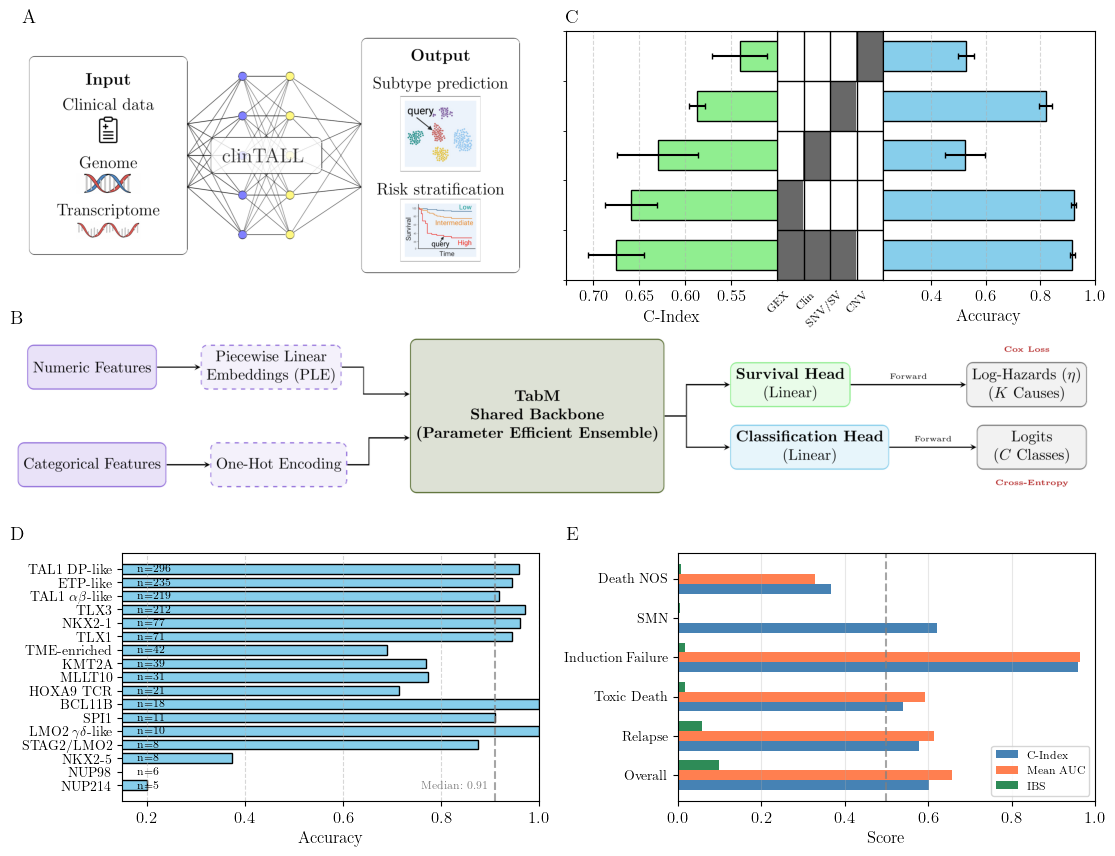

In [27]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from pdf2image import convert_from_path

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "font.size": 12,
    "axes.labelsize": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# Main GridSpec - only controls rows
fig = plt.figure(figsize=(14, 10))
gs_main = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.05)

# Row 0: Two columns with wspace=0.2
gs_row0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_main[0], wspace=0.05)

# Row 1: Full width (no wspace needed)
gs_row1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[1])

# Row 2: Two columns with larger wspace=0.35
gs_row2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_main[2], wspace=0.05)

# --- Panel A: gabs diagram (top-left) ---
ax_a = fig.add_subplot(gs_row0[0])
images_gabs = convert_from_path("gabs.pdf", dpi=600)
ax_a.imshow(images_gabs[0])
ax_a.axis('off')
ax_a.set_title('A', loc='left', fontweight='bold', fontsize=14)

# --- Panel C: Data sources comparison (top-right) ---
gs_c = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_row0[1], 
                                         width_ratios=[1, 0.5, 1], wspace=0.0)


overall_res = pd.read_csv('res/all_results_df.csv', index_col=0)
overall_res.columns = ['c', 'a']
overall_res[['c_index_mean', 'c_index_std']] = overall_res['c'].str.strip('()').str.split(',', expand=True).astype(float)
overall_res[['accuracy_mean', 'accuracy_std']] = overall_res['a'].str.strip('()').str.split(',', expand=True).astype(float)
overall_res = overall_res.sort_values(by='c_index_mean', ascending=False)
overall_res_clean = overall_res.drop(columns=['c', 'a']).sort_values(by='c_index_mean', ascending=False)

modalities = overall_res_clean.index.to_list()[1:]
heatmap_data = np.array([[1 if (idx == 'Combined' and mod != 'CNV') or idx == mod else 0 
                          for mod in modalities] for idx in overall_res_clean.index])
y_pos = np.arange(len(overall_res_clean))

ax_c1 = fig.add_subplot(gs_c[0])
ax_c1.barh(y_pos, overall_res_clean['c_index_mean'], xerr=overall_res_clean['c_index_std'],
           color='lightgreen', edgecolor='black', height=0.6, capsize=2)
ax_c1.invert_xaxis()
ax_c1.set_xlim(0.725, 0.5)
ax_c1.set_xlabel('C-Index')
ax_c1.set_title('C', loc='left', fontweight='bold', fontsize=14)
ax_c1.grid(axis='x', linestyle='--', alpha=0.5)
ax_c1.tick_params(axis='y', left=False, labelleft=False)
ax_c1.set_xticks([0.55, 0.6, 0.65, 0.7, 0.73], labels=['0.55', '0.60', '0.65', '0.70', ''])

ax_c2 = fig.add_subplot(gs_c[1], sharey=ax_c1)
"""ax_c2.imshow(heatmap_data, cmap='Greys', aspect='auto', vmin=0, vmax=1.5, origin='lower')
ax_c2.set_xticks(np.arange(len(modalities)))
ax_c2.set_xticklabels(['GEX', 'Clin', 'CNV', 'SNV'], rotation=45, ha='right', fontsize=8)
ax_c2.tick_params(bottom=False, left=False, labelleft=False)"""
ax_c2.imshow(heatmap_data, cmap='Greys', aspect='auto', vmin=0, vmax=1.5, origin='lower')
ax_c2.set_xticks(np.arange(len(modalities)))
# sort x tick labels to match heatmap orientation

shorthanded_modalities = {'Gene_id': 'GEX', 'Clinical_vars': 'Clin', 'CNV': 'CNV', 'Variants': 'SNV/SV'}
ax_c2.set_xticklabels([shorthanded_modalities.get(mod, 'NameError') for mod in modalities], rotation=45, ha='right', fontsize=8)#['GEX', 'Clin', 'CNV', 'SNV']
ax_c2.tick_params(bottom=False, left=False, labelleft=False)

# Add grid lines around heatmap cells
ax_c2.set_xticks(np.arange(len(modalities) + 1) - 0.5, minor=True)
ax_c2.set_yticks(np.arange(len(overall_res_clean) + 1) - 0.5, minor=True)
ax_c2.grid(which="minor", color="black", linestyle='-', linewidth=1)
ax_c2.tick_params(which="minor", bottom=False, left=False)

ax_c3 = fig.add_subplot(gs_c[2], sharey=ax_c1)
ax_c3.barh(y_pos, overall_res_clean['accuracy_mean'], xerr=overall_res_clean['accuracy_std'],
           color='skyblue', edgecolor='black', height=0.6, capsize=2)
ax_c3.set_xlim(0.224, 1.0)
ax_c3.set_xlabel('Accuracy')
ax_c3.grid(axis='x', linestyle='--', alpha=0.5)
ax_c3.tick_params(axis='y', left=False, labelleft=False)

# --- Panel B: Architecture diagram (middle, full width) ---
ax_b = fig.add_subplot(gs_row1[0])
images_arch = convert_from_path("architecture3.pdf", dpi=600)
ax_b.imshow(images_arch[0])
ax_b.axis('off')
ax_b.set_title('B', loc='left', fontweight='bold', fontsize=14)

# --- Panel D: Per-class accuracy (bottom-left) ---
ax_d = fig.add_subplot(gs_row2[0])

gex_pred_labels = pd.read_csv('res/all_pred_labels_EFS_tuned_Combined.csv', index_col=0).idxmax(axis=1)
gex_pred_labels = pd.DataFrame([i.split('_')[1] for i in gex_pred_labels], index=gex_pred_labels.index, columns=['Predicted'])
common_samples = labels.index.intersection(gex_pred_labels.index).to_list()
gex_pred_labels = gex_pred_labels.loc[common_samples]
labels_subset = labels.loc[common_samples].replace({
    'LMO2 γδ-like': r'LMO2 $\gamma\delta$-like',
    'TAL1 αβ-like': r'TAL1 $\alpha\beta$-like'
})
gex_pred_labels = gex_pred_labels.replace({
    'LMO2 γδ-like': r'LMO2 $\gamma\delta$-like',
    'TAL1 αβ-like': r'TAL1 $\alpha\beta$-like'
})

unique_labels = labels_subset.value_counts().index.tolist()[::-1]
cm = confusion_matrix(labels_subset, gex_pred_labels, labels=unique_labels)
class_counts = cm.sum(axis=1)
per_class_acc = np.divide(cm.diagonal(), class_counts, out=np.zeros_like(cm.diagonal(), dtype=float), where=class_counts!=0)

y_pos_d = np.arange(len(unique_labels))
bars = ax_d.barh(y_pos_d, per_class_acc, color='skyblue', edgecolor='black', height=0.7)
ax_d.set_yticks(y_pos_d)
ax_d.set_yticklabels(unique_labels, fontsize=10)
ax_d.set_xlabel("Accuracy")
ax_d.set_xlim(0.15, 1)
ax_d.grid(axis='x', linestyle='--', alpha=0.5)
#ax_d.set_title('D', loc='left', fontweight='bold', fontsize=14)

for bar, n in zip(bars, class_counts):
    ax_d.text(0.18, bar.get_y() + bar.get_height()/2, f'n={n}', 
              va='center', ha='left', fontsize=8)
    
# add a dashed v_line at median accuracy
median_acc = np.median(per_class_acc)
ax_d.axvline(x=median_acc, color='gray', linestyle='--', alpha=0.7)
# annotate median accuracy
ax_d.text(median_acc - 0.15,  0, f'Median: {median_acc:.2f}', 
          color='gray', fontsize=8, va='center')
pos_d = ax_d.get_position()
ax_d.set_position([pos_d.x0 + 0.08, pos_d.y0, pos_d.width - 0.08, pos_d.height])
# Place title at the new left edge (where y-labels start)
fig.text(pos_d.x0 , pos_d.y0 + pos_d.height + 0.01, 'D', fontweight='bold', fontsize=14, 
         va='bottom', ha='left')

# --- Panel E: Event type performance (bottom-right) ---
ax_e = fig.add_subplot(gs_row2[1])

df_results = pd.read_csv('Event_type_perf.csv', index_col=0)
metrics_to_plot = ['C_Index', 'AUC_Mean', 'IBS']
df_plot_T = df_results.loc[metrics_to_plot].astype(float).T
y = np.arange(len(df_plot_T.index))
height = 0.25

for i, (metric, label, color) in enumerate(zip(metrics_to_plot, ['C-Index', 'Mean AUC', 'IBS'], 
                                                ['steelblue', 'coral', 'seagreen'])):
    offset = (i - len(metrics_to_plot)/2 + 0.5) * height
    ax_e.barh(y + offset, df_plot_T[metric], height, label=label, color=color)

ax_e.set_xlabel('Score')
ax_e.set_yticks(y)
y_ticks = df_plot_T.index.to_series().replace({'Second Malignant Neoplasm': 'SMN'})
ax_e.set_yticklabels(y_ticks, fontsize=10)
ax_e.legend(loc='lower right', fontsize=8)
ax_e.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7)
ax_e.set_xlim(0, 1.0)
ax_e.grid(axis='x', alpha=0.3)

# Shrink plot width and shift right to align y-labels with title
pos_e = ax_e.get_position()
ax_e.set_position([pos_e.x0 + 0.08, pos_e.y0, pos_e.width - 0.08, pos_e.height])
# Place title at the new left edge (where y-labels start)
fig.text(pos_e.x0 , pos_e.y0 + pos_e.height + 0.01, 'E', fontweight='bold', fontsize=14, 
         va='bottom', ha='left')
#ax_e.set_title('E', loc='left', fontweight='bold', fontsize=14)

plt.savefig('fig1.pdf', dpi=600, bbox_inches='tight', transparent=True)